# Imports

In [1]:
import os
import json
import glob
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import inspect
import logging
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import imageio.v3 as imageio
from tqdm.auto import tqdm
from torchvision.utils import make_grid
import transformers
from transformers import CLIPTextModel, CLIPTokenizer, CLIPImageProcessor
import diffusers

from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDIMScheduler,
    UNet2DConditionModel
)


2025-08-09 12:50:38.122680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754743838.312938      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754743838.370623      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, rank=512, alpha=1.0):
        super().__init__()
        if not isinstance(original_linear, nn.Linear):
            raise TypeError(f"LoRALinear only supports nn.Linear, but got: {type(original_linear)}")

        self.original = original_linear
        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank

        in_features = original_linear.in_features
        out_features = original_linear.out_features

        self.lora_A = nn.Parameter(torch.randn(rank, in_features) * 0.01)
        self.lora_B = nn.Parameter(torch.randn(out_features, rank) * 0.01)

        for param in self.original.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.original(x) + self.scaling * (x @ self.lora_A.T @ self.lora_B.T)



def init_lora_attn(model, lora_rank=512, alpha=1.0, train = False):
    lora_layers = nn.ModuleList()

    # Freeze all original parameters first
    for param in model.parameters():
        param.requires_grad = False

    for name, module in model.named_modules():
        if name.endswith("attn1") or name.endswith("attn2"):
            attn = module

            # Replace and register LoRA for to_q, to_k, to_v
            for proj_name in ['to_q', 'to_k', 'to_v']:
                orig_layer = getattr(attn, proj_name)
                lora_layer = LoRALinear(orig_layer, rank=lora_rank, alpha=alpha)
                setattr(attn, proj_name, lora_layer)
                lora_layers.append(lora_layer)

            # to_out usually ModuleList or Sequential, replace first layer
            if isinstance(attn.to_out, (nn.ModuleList, nn.Sequential)):
                orig_out = attn.to_out[0]
                lora_out = LoRALinear(orig_out, rank=lora_rank, alpha=alpha)
                attn.to_out[0] = lora_out
                lora_layers.append(lora_out)

    if train:
        for lora_layer in lora_layers:
            for param in lora_layer.parameters():
                param.requires_grad = True

    return lora_layers

In [3]:

def preprocess_controlnet_image(image: Image.Image, device, dtype=torch.float32):
    image = image.resize((512, 512))
    img_array = np.array(image).astype(np.float32) / 255.0  # normalize to [0,1]
    
    if img_array.ndim == 2:  # Grayscale
        img_array = img_array[None, None, :, :]
    elif img_array.shape[2] == 3:  # RGB
        img_array = img_array.transpose(2, 0, 1)[None, :, :, :]
    else:
        raise ValueError("Unexpected image shape.")

    return torch.tensor(img_array, device=device, dtype=dtype)

def encode_prompt(prompt: str, tokenizer, text_encoder, device):
    inputs = tokenizer(
        [prompt],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    with torch.no_grad():
        return text_encoder(input_ids, attention_mask=attention_mask).last_hidden_state

@torch.no_grad()
def run_controlnet_inference(
    prompt: str,
    control_image: Image.Image,
    noise_scheduler,
    tokenizer,
    text_encoder,
    vae,
    unet,
    controlnet,
    num_inference_steps=50,
    guidance_scale=7.5,
    device=None,
    weight_dtype=torch.float32,
    inject_lora=False,
    lora_path=""
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # Optionally inject LoRA weights
    if inject_lora:
        needs_lora = False
        for name, module in controlnet.named_modules():
            if name.endswith("attn1") or name.endswith("attn2"):
                for proj_name in ['to_q', 'to_k', 'to_v']:
                    proj = getattr(getattr(module, proj_name), "__class__", None)
                    if proj is not None and "LoRALinear" in proj.__name__:
                        needs_lora = True
                        break
        if needs_lora:
            print(f"[INFO] Injecting LoRA weights from: {lora_path}")
            controlnet.load_state_dict(torch.load(lora_path, map_location=device), strict=False)
        else:
            print("[WARNING] LoRA injection skipped: No LoRALinear layers found in controlnet.")

    # Encode prompt
    cond_embeds = encode_prompt(prompt, tokenizer, text_encoder, device)
    uncond_embeds = encode_prompt("", tokenizer, text_encoder, device)
    prompt_embeds = torch.cat([uncond_embeds, cond_embeds], dim=0)

    # Preprocess controlnet image
    controlnet_image = preprocess_controlnet_image(control_image, device=device, dtype=weight_dtype)
    controlnet_image = torch.cat([controlnet_image, controlnet_image], dim=0)  # guidance duplication

    # Prepare latents
    batch_size = 1
    latent_shape = (batch_size, unet.in_channels, 64, 64)
    latents = torch.randn(latent_shape, device=device, dtype=weight_dtype) * noise_scheduler.init_noise_sigma

    noise_scheduler.set_timesteps(num_inference_steps)

    for t in noise_scheduler.timesteps:
        latent_input = torch.cat([latents] * 2)
        latent_input = noise_scheduler.scale_model_input(latent_input, t)

        # ControlNet forward
        down_block_res_samples, mid_block_res_sample = controlnet(
            latent_input,
            t,
            encoder_hidden_states=prompt_embeds,
            controlnet_cond=controlnet_image,
            return_dict=False,
        )

        # UNet forward
        noise_pred = unet(
            latent_input,
            t,
            encoder_hidden_states=prompt_embeds,
            down_block_additional_residuals=[res.to(dtype=weight_dtype) for res in down_block_res_samples],
            mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
            return_dict=False,
        )[0]

        # CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Latent update
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample

    # Postprocess
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
    image = (image * 255).round().astype("uint8")
    return Image.fromarray(image)



def show_images_side_by_side(images, titles=None):
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axs = [axs]
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
        if titles is not None:
            axs[i].set_title(titles[i])
    plt.show()

In [4]:
pretrained_model_path = "runwayml/stable-diffusion-v1-5"
controlnet_model_path = "lllyasviel/sd-controlnet-canny"

# Load scheduler, tokenizer and models.
noise_scheduler = DDIMScheduler.from_pretrained(pretrained_model_path, subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(pretrained_model_path, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(pretrained_model_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(pretrained_model_path, subfolder="unet")
controlnet = ControlNetModel.from_pretrained(controlnet_model_path)

# Freeze vae, unet and text_encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_dtype = torch.float32



# Move models to device with specified dtype
text_encoder.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
unet.to(device, dtype=weight_dtype)

## change linear layers to LORA Linear layers
lora_layers = init_lora_attn(controlnet, lora_rank=512)
controlnet.to(device, dtype=weight_dtype)


##Load Finetuned Model
pretrained_weights_path = "/kaggle/input/lora-weights-full/lora_v1.pth"  
controlnet.load_state_dict(torch.load(pretrained_weights_path, map_location=device))

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

<All keys matched successfully>

# Load Validation Image and Run Generation

In [7]:
val_img = Image.open("/kaggle/input/val-image/whereness assignment sketch.png")

Guidance_prompt: Rectangular house with flat roof made of concrete


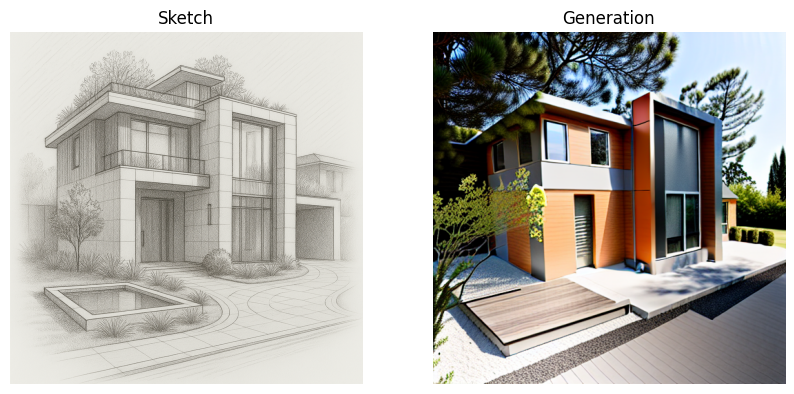

In [9]:
import warnings
warnings.filterwarnings("ignore")

prompt="Rectangular house with flat roof made of concrete"
controlnet.eval()
with torch.no_grad():
    generated_image = run_controlnet_inference(
        prompt=prompt,
        control_image=val_img,
        noise_scheduler=noise_scheduler,
        tokenizer=tokenizer,
        text_encoder=text_encoder,
        vae=vae,
        unet=unet,
        num_inference_steps = 25,
        controlnet=controlnet,
        device=device,
        weight_dtype=weight_dtype,
        inject_lora=False
    )

print(f'Guidance_prompt: {prompt}')
show_images_side_by_side(
    [val_img, generated_image],
    titles=["Sketch", "Generation"]
)


In [ ]:


# Path to sketches and prompts
sketch_folder = "/kaggle/input/sketch-2-image-dataset/construction_sketch_dataset/construction_sketch_dataset/Sketches"
prompts_path = "/kaggle/input/sketch-2-image-dataset/prompts.json"  

# Load prompts from JSON
with open(prompts_path, "r") as f:
    prompts_list = json.load(f)

prompts_dict = {item["image"]: item["prompt"] for item in prompts_list}

# Ensure model is in eval mode
controlnet.eval()
unet.eval()
vae.eval()
text_encoder.eval()

# Get list of image paths
image_files = [os.path.join(sketch_folder, f) for f in os.listdir(sketch_folder)
               if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# Iterate over all sketches
with torch.no_grad():
    for image_path in tqdm(image_files, desc="Generating from sketches"):
        # Extract filename
        filename = os.path.basename(image_path)

        # Get corresponding prompt (fallback to empty if not found)
        prompt = prompts_dict.get(filename.replace("sketch_", "image_"), "")

        # Load sketch image
        pil_image = Image.open(image_path).convert("RGB")

        # Run inference
        generated_image = run_controlnet_inference(
            prompt=prompt,
            control_image=pil_image,
            noise_scheduler=noise_scheduler,
            tokenizer=tokenizer,
            num_inference_steps=50,
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            controlnet=controlnet,
            device=device,
            weight_dtype=weight_dtype,
            inject_lora=False
        )


        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(pil_image)
        ax[0].set_title("Original Sketch")
        ax[0].axis("off")
        ax[1].imshow(generated_image)
        ax[1].set_title("Generated Image")
        ax[1].axis("off")
        plt.suptitle(f"{filename} | Prompt: {prompt}")
        plt.tight_layout()
        plt.show()
